# Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess = tf.InteractiveSession()

# MNIST

MNIST is a database of handwritten digits. The images are 28x28 greyscale images (encoded as 784-dimensional vectors in row-major order). There are 60,000 images in the training set, and there are 10,000 images in the test set.

Why is there a train-test split? We care about how our function generalizes, and so we want to benchmark its performance on a set of data that it hasn't seen before. Otherwise, a "perfect" learning algorithm could just memorize all the data points, but this algorithm wouldn't generalize well.

Let's see what one of the MNIST images looks like.

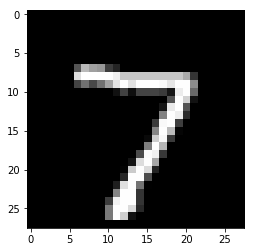

In [4]:
plt.imshow(mnist.test.images[0].reshape(28, 28), cmap='gray')

Let's check the label of this image. The MNIST labels are encoded in one-hot format. There are 10 possible labels, and the vector with label $i$ is the $i$-dimensional vector that has the entry $1$ in the $i$th position and $0$s elsewhere.

In [5]:
mnist.test.labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [6]:
np.argmax(mnist.test.labels[0])

7

# Fully-connected neural network

Let's design a fully-connected neural network to classify MNIST digits. It should take a 784-dimensional input and give a 10-dimensional one-hot encoded probability distribution as output.

In [7]:
x = tf.placeholder(tf.float32, (None, 28*28)) # batch of inputs
y_ = tf.placeholder(tf.float32, (None, 10)) # batch of corresponding labels

In [8]:
# this corresponds with the model of a neuron in [ 02-01-notes ]
# except this is describing an entire layer, not a single neuron
# and we're not including the activation function inside here

def fully_connected(x, input_dimension, output_dimension):
    w = tf.Variable(tf.random_normal((input_dimension, output_dimension)))
    b = tf.Variable(tf.random_normal((output_dimension,)))
    
    return tf.matmul(x, w) + b

Let's start with a really simple neural network with only one fully-connected layer (the output layer) with 10 neurons.

See [ 02-04-notes ] for an architecture diagram.

In [9]:
y = fully_connected(x, 784, 10)

Above, $y$ is a 10-dimensional vector, but it's not a probability distribution. We can fix that by applying the softmax function to the logits $y$:

$$\sigma(y)_i = \frac{e^{y_i}}{\sum_j e^{y_j}}$$

And we can define loss as the cross entropy between the true probability distribution (the labels) $p$ and the predicted probability distribution $q$:

$$H(p, q) = - \sum_i p(x) \log q(x)$$

In TensorFlow, we can do both of these in a single step (also needed for numerical stability):

In [10]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

We have 60000 training points, so we'll be doing minibatch stochastic gradient descent to train our network (instead of computing gradients over all 60000 data points).

In [12]:
BATCH_SIZE = 100
ITERATIONS = 1000

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    sess.run(optimizer, {x: x_batch, y_: y_batch})

## Evaluation

Let's evaluate the accuracy of our network over the test set.

In [13]:
def accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, 1) == np.argmax(labels, 1))

In [14]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.8699

# Deep fully-connected network

Will adding a ton of parameters help us find a better solution? Let's use a deep fully-connected network using layers with 2000, 1000, and 100 neurons in the hidden layers and then 10 neurons in the output layer. Let's use ReLU activation for all the hidden layers. See [ 02-05-notes ] for an architecture diagram.

In [15]:
fc1 = tf.nn.relu(fully_connected(x, 784, 2000))
fc2 = tf.nn.relu(fully_connected(fc1, 2000, 1000))
fc3 = tf.nn.relu(fully_connected(fc2, 1000, 100))
fc4 = fully_connected(fc3, 100, 10)

y = fc4

Our initial network had ~8,000 parameters. The above network has ~3.5 million parameters, which is over 400x the capacity of the first one.

In [16]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

Let's use a fancier optimizer this time.

In [17]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [18]:
BATCH_SIZE = 50
ITERATIONS = 5000 # this takes ~ 2 minutes on my laptop

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    l, _ = sess.run([loss, optimizer], {x: x_batch, y_: y_batch})
    if (i+1) % 100 == 0:
        print('iteration %d, batch loss %f' % (i+1, np.mean(l)))

iteration 100, batch loss 1524.092163
iteration 200, batch loss 2593.736328
iteration 300, batch loss 1095.994141
iteration 400, batch loss 982.541748
iteration 500, batch loss 986.342651
iteration 600, batch loss 732.789795
iteration 700, batch loss 1450.782837
iteration 800, batch loss 689.906555
iteration 900, batch loss 398.776398
iteration 1000, batch loss 335.374756
iteration 1100, batch loss 593.934448
iteration 1200, batch loss 1487.456299
iteration 1300, batch loss 2010.209351
iteration 1400, batch loss 170.993164
iteration 1500, batch loss 330.138214
iteration 1600, batch loss 0.000000
iteration 1700, batch loss 310.644623
iteration 1800, batch loss 39.443127
iteration 1900, batch loss 906.453918
iteration 2000, batch loss 122.963959
iteration 2100, batch loss 414.156403
iteration 2200, batch loss 225.709030
iteration 2300, batch loss 162.094055
iteration 2400, batch loss 185.161530
iteration 2500, batch loss 94.067307
iteration 2600, batch loss 66.464867
iteration 2700, batc

## Evaluation

In [19]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.9529

# Convolutional neural network

Let's design a convolutional neural network to classify MNIST digits.

In [20]:
x_image = tf.reshape(x, (-1, 28, 28, 1)) # turn our 784-dimensional vector into a 28x28 image

In [21]:
# a convolutional layer

def convolve(x, kernel_height, kernel_width, input_channels, output_channels):
    w = tf.Variable(tf.random_normal((kernel_height, kernel_width, input_channels, output_channels)))
    b = tf.Variable(tf.random_normal((output_channels,)))
    
    return tf.nn.conv2d(x, w, strides=(1, 1, 1, 1), padding='SAME')

In [22]:
# a 2x2 max pooling layer

def pool(x):
    return tf.nn.max_pool(x, (1, 2, 2, 1), (1, 2, 2, 1), padding='SAME')

## Network architecture

Let's design an architecture with the following layers:

* convolution layer with 25 3x3 filters, relu activation
* 2x2 max pooling layer
* convolution layer with 50 3x3 filters, relu activation
* 2x2 max pooling layer
* fully-connected layer with 1000 neurons, relu activation
* fully-connected output layer (10 neurons)

See [ 02-06-notes ] for an architecture diagram.

In [23]:
conv1 = tf.nn.relu(convolve(x_image, 3, 3, 1, 25))
pool1 = pool(conv1)
conv2 = tf.nn.relu(convolve(pool1, 3, 3, 25, 50))
pool2 = pool(conv2)
pool2_flat = tf.reshape(pool2, (-1, 7 * 7 * 50))
fc1 = tf.nn.relu(fully_connected(pool2_flat, 7 * 7 * 50, 1000))
fc2 = fully_connected(fc1, 1000, 10)

y = fc2

This network has approximately 2.5 million parameters. Note that this is about 1 million parameters _fewer_ than the deep fully-connected network.

In [24]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

In [25]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [26]:
BATCH_SIZE = 50
ITERATIONS = 5000 # this takes ~ 3.5 minutes on my laptop

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    l, _ = sess.run([loss, optimizer], {x: x_batch, y_: y_batch})
    if (i+1) % 100 == 0:
        print('iteration %d, batch loss %f' % (i+1, np.mean(l)))

iteration 100, batch loss 904.771484
iteration 200, batch loss 276.587616
iteration 300, batch loss 453.983093
iteration 400, batch loss 406.946472
iteration 500, batch loss 100.544708
iteration 600, batch loss 114.825882
iteration 700, batch loss 133.377121
iteration 800, batch loss 126.084885
iteration 900, batch loss 430.765533
iteration 1000, batch loss 46.572891
iteration 1100, batch loss 343.002045
iteration 1200, batch loss 85.059456
iteration 1300, batch loss 42.467697
iteration 1400, batch loss 165.551407
iteration 1500, batch loss 129.811783
iteration 1600, batch loss 0.000000
iteration 1700, batch loss 43.886387
iteration 1800, batch loss 341.299652
iteration 1900, batch loss 76.959167
iteration 2000, batch loss 84.741837
iteration 2100, batch loss 125.253632
iteration 2200, batch loss 110.654861
iteration 2300, batch loss 73.772011
iteration 2400, batch loss 0.000000
iteration 2500, batch loss 0.000000
iteration 2600, batch loss 270.552063
iteration 2700, batch loss 48.3199

## Evaluation

In [27]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.9756

## Visualization

Let's see what some intermediate activations look like

In [28]:
conv1_, conv2_ = sess.run([conv1, conv2], {x: mnist.test.images[0:1]})

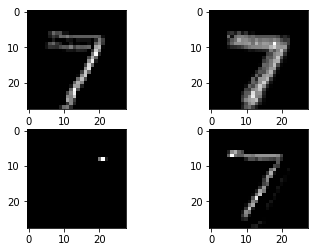

In [29]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(conv1_[0,:,:,0], cmap='gray')
ax[0, 1].imshow(conv1_[0,:,:,1], cmap='gray')
ax[1, 0].imshow(conv1_[0,:,:,2], cmap='gray')
ax[1, 1].imshow(conv1_[0,:,:,3], cmap='gray')

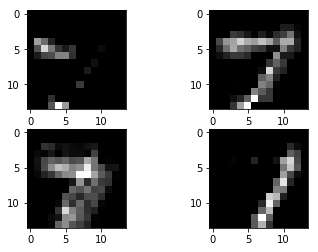

In [30]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(conv2_[0,:,:,0], cmap='gray')
ax[0, 1].imshow(conv2_[0,:,:,1], cmap='gray')
ax[1, 0].imshow(conv2_[0,:,:,2], cmap='gray')
ax[1, 1].imshow(conv2_[0,:,:,3], cmap='gray')